In [1]:
%load_ext autoreload
%autoreload 2

In [69]:
import os
import sys

sys.path.insert(0, os.path.abspath(".."))
from dotenv import load_dotenv
import seaborn as sns
import pandas as pd
import numpy as np

from db import PostgresDB
from schemas import Proband
from matplotlib import pyplot as plt


In [3]:
load_dotenv()


True

In [4]:
db = PostgresDB(
    db_name=os.getenv("DB_NAME"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT"),
    user=os.getenv("DB_USER"),
)


Connected to database


In [5]:
ICU_SCHEMA = "mimiciv_icu"
HOSP_SCHEMA = "mimiciv_hosp"
ED_SCHEMA = "mimiciv_ed"


In [6]:
def create_sepsis_cohort(db: PostgresDB):
    probands = []
    query = """
        SELECT sep.subject_id, sep.stay_id, sta.hadm_id
        FROM mimiciv_derived.sepsis3 sep, mimiciv_icu.icustays sta
        WHERE sep.stay_id = sta.stay_id limit 100;
    """
    db_result = db.execute_query(query)
    for subject_id, stay_id, hadm_id in db_result:
        probands.append(
            Proband(subject_id=subject_id, stay_id=stay_id, hadm_id=hadm_id)
        )
    cohort = Cohort(participants=probands)
    return cohort


In [7]:
from cohorts import Cohort, Proband

sepsis_query = """
    SELECT sep.subject_id, sta.hadm_id
    FROM mimiciv_derived.sepsis3 sep, mimiciv_icu.icustays sta
    WHERE sep.stay_id = sta.stay_id
    ORDER BY RANDOM()
    LIMIT 100;
"""

kdigo_query = """
    SELECT kdigo.subject_id, sta.hadm_id
    FROM mimiciv_derived.kdigo_stages kdigo, mimiciv_icu.icustays sta
    WHERE kdigo.stay_id = sta.stay_id AND kdigo.aki_stage > 2
    ORDER BY RANDOM()
    LIMIT 100;
"""

meld_query = """
    SELECT meld.subject_id, sta.hadm_id
    FROM mimiciv_derived.meld meld, mimiciv_icu.icustays sta
    WHERE meld.stay_id = sta.stay_id AND meld.meld > 32
    ORDER BY RANDOM()
    LIMIT 100;
"""

cardiac_query = """
    SELECT card.subject_id, card.hadm_id
    FROM mimiciv_derived.cardiac_marker card
    WHERE card.hadm_id IS NOT NULL AND card.ntprobnp > 500
    ORDER BY RANDOM()
    LIMIT 100;
"""


In [19]:
COUNT_PER_GROUP = 60

sepsis_pats = db.execute_query(sepsis_query)
meld_pats = db.execute_query(meld_query)
kdigo_pats = db.execute_query(kdigo_query)
card_pats = db.execute_query(cardiac_query)

groups = [sepsis_pats]

participants = []
for group in groups:
    count = 0
    for pat in group:
        if pat[0] not in [p.subject_id for p in participants] and pat[1] not in [
            p.hadm_id for p in participants
        ]:
            participants.append(Proband(subject_id=pat[0], hadm_id=pat[1]))
            count += 1
        if count == COUNT_PER_GROUP:
            break


In [22]:
cohort = Cohort(participants=participants, db=db)


In [26]:
cohort.initialize_data(with_tfidf_diagnoses=True)
result = cohort.compare_encounters(
    demographics_weight=0.1,
    diagnoses_weight=0.3,
    labevents_weight=0.6,
    aggregate_method="mean",
    normalize_categories=True,
)


Finished encounter 28150960
Finished encounter 24907449
Finished encounter 20554296
Finished encounter 21201633
Finished encounter 21561906
Finished encounter 28904251
Finished encounter 20206823
Finished encounter 24003577
Finished encounter 22145629
Finished encounter 23817758
Finished encounter 21521157
Finished encounter 27493582
Finished encounter 23381725
Finished encounter 27560524
Finished encounter 25447065
Finished encounter 24483493
Finished encounter 27820603
Finished encounter 23848435
Finished encounter 29417806
Finished encounter 27774949
Normalizing categories by sclaing to range 0..1


In [27]:
columne_names = [p.hadm_id for p in cohort.participants]
data = [e["similarity"] for e in result]
data = np.array(data).reshape(len(columne_names), len(columne_names))
df = pd.DataFrame(data=data, columns=columne_names, index=columne_names)


In [28]:
df.shape


(20, 20)

<Axes: >

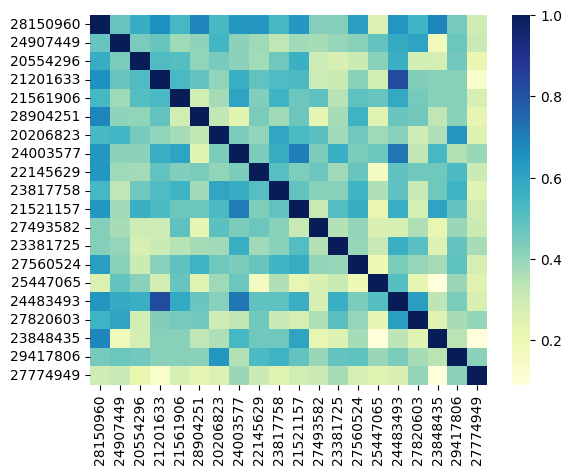

In [29]:
sns.heatmap(df, cmap="YlGnBu", fmt=".2f")


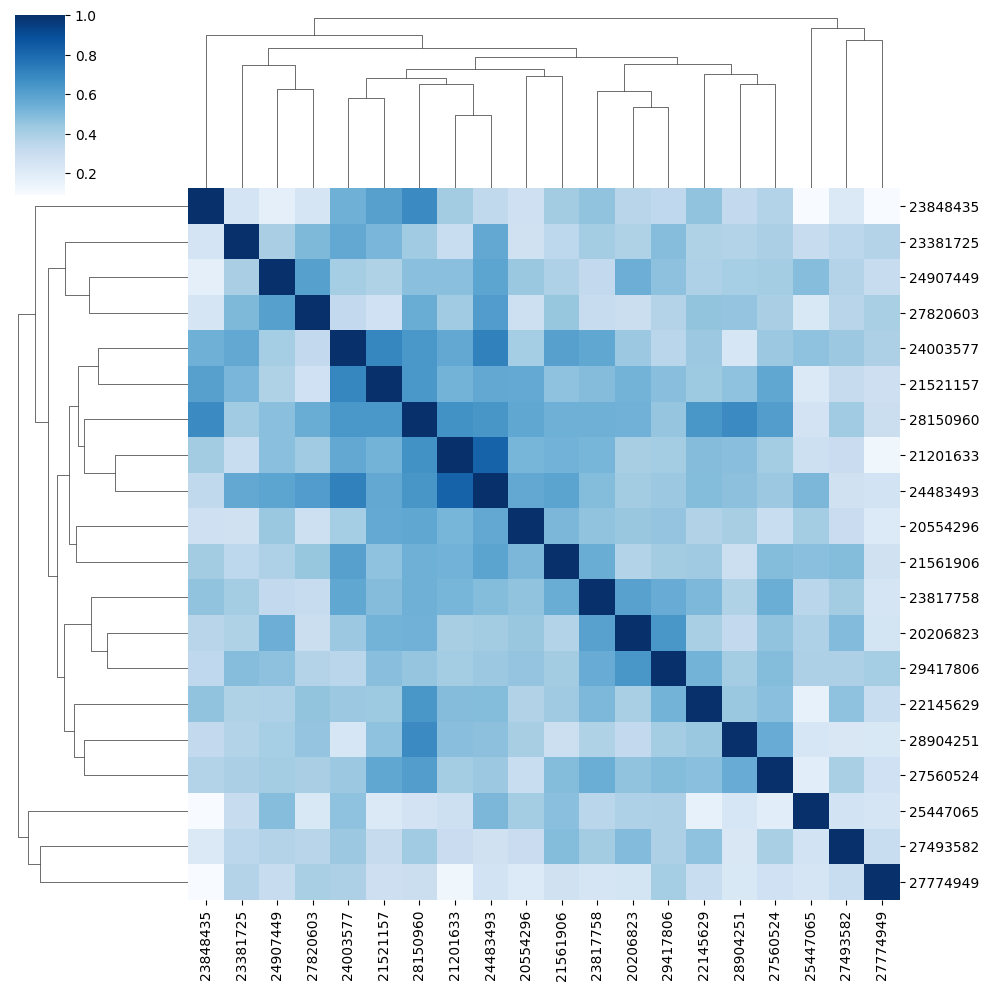

In [30]:
sns.clustermap(df, annot=False, fmt=".2f", cmap="Blues")


In [31]:
from sklearn.manifold import MDS


In [32]:
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation


In [33]:
meld_encounters = [e[1] for e in meld_pats]
sepsis_encounters = [e[1] for e in sepsis_pats]
# kdigo_pats = [e[1] for e in kdigo_pats]
card_pats = [e[1] for e in card_pats]


In [66]:
N_CLUSTERS = 4
spectral_cluster = SpectralClustering(
    n_clusters=N_CLUSTERS, affinity="precomputed", n_init=100
).fit(df)
agglomerative_cluster = AgglomerativeClustering(
    n_clusters=N_CLUSTERS, affinity="precomputed", linkage="average"
).fit(df)
kmeans_cluster = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(df)
dbscan_cluster = DBSCAN(eps=0.5, min_samples=2).fit(df)
affinity_cluster = AffinityPropagation().fit(df)

clusters = [
    spectral_cluster,
    agglomerative_cluster,
    kmeans_cluster,
    dbscan_cluster,
    affinity_cluster,
]


/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [67]:
for cluster in clusters:
    print(f"Cluster: {cluster.__class__.__name__}")
    print("------------------")
    for index, group in enumerate(groups):
        print(cluster.labels_[index * COUNT_PER_GROUP : (index + 1) * COUNT_PER_GROUP])
    print("\n")


Cluster: SpectralClustering
------------------
[1 0 1 1 1 1 0 1 1 1]
[1 0 0 1 0 0 0 1 0 0]


Cluster: AgglomerativeClustering
------------------
[1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]


Cluster: KMeans
------------------
[0 1 0 0 0 0 1 0 0 0]
[0 1 1 0 1 0 1 0 1 1]


Cluster: DBSCAN
------------------
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


Cluster: AffinityPropagation
------------------
[2 5 0 0 0 3 1 2 3 1]
[2 1 5 3 4 0 5 2 1 6]




/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<Axes: >

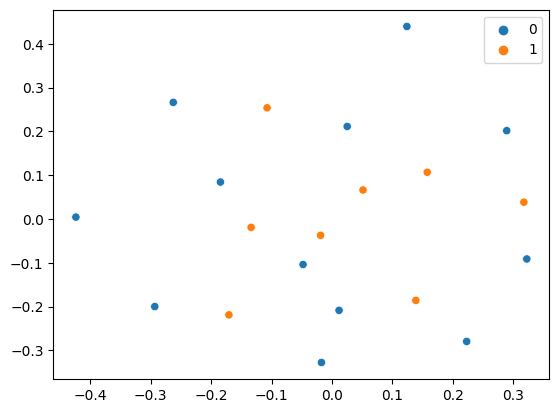

In [36]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(df)
sns.scatterplot(x=pos[:, 0], y=pos[:, 1], hue=kmeans_cluster.labels_, cmap="Set1")


In [90]:
# plot the los_hosp and los_icu for each cluster in a different scatterplot
def plot_endpoint_for_cluster(
    cohort, cluster, endpoint, x_axis="cluster", hue="cluster", ax=None
):
    y_axis = endpoint
    data = pd.DataFrame(
        {
            x_axis: cluster.labels_,
            y_axis: [getattr(e, endpoint) for e in cohort.participants],
            hue: cluster.labels_,
        }
    )
    if ax is None:
        sns.scatterplot(x=x_axis, y=y_axis, hue=hue, data=data, palette="Set1")
    else:
        sns.scatterplot(x=x_axis, y=y_axis, hue=hue, data=data, palette="Set1", ax=ax)


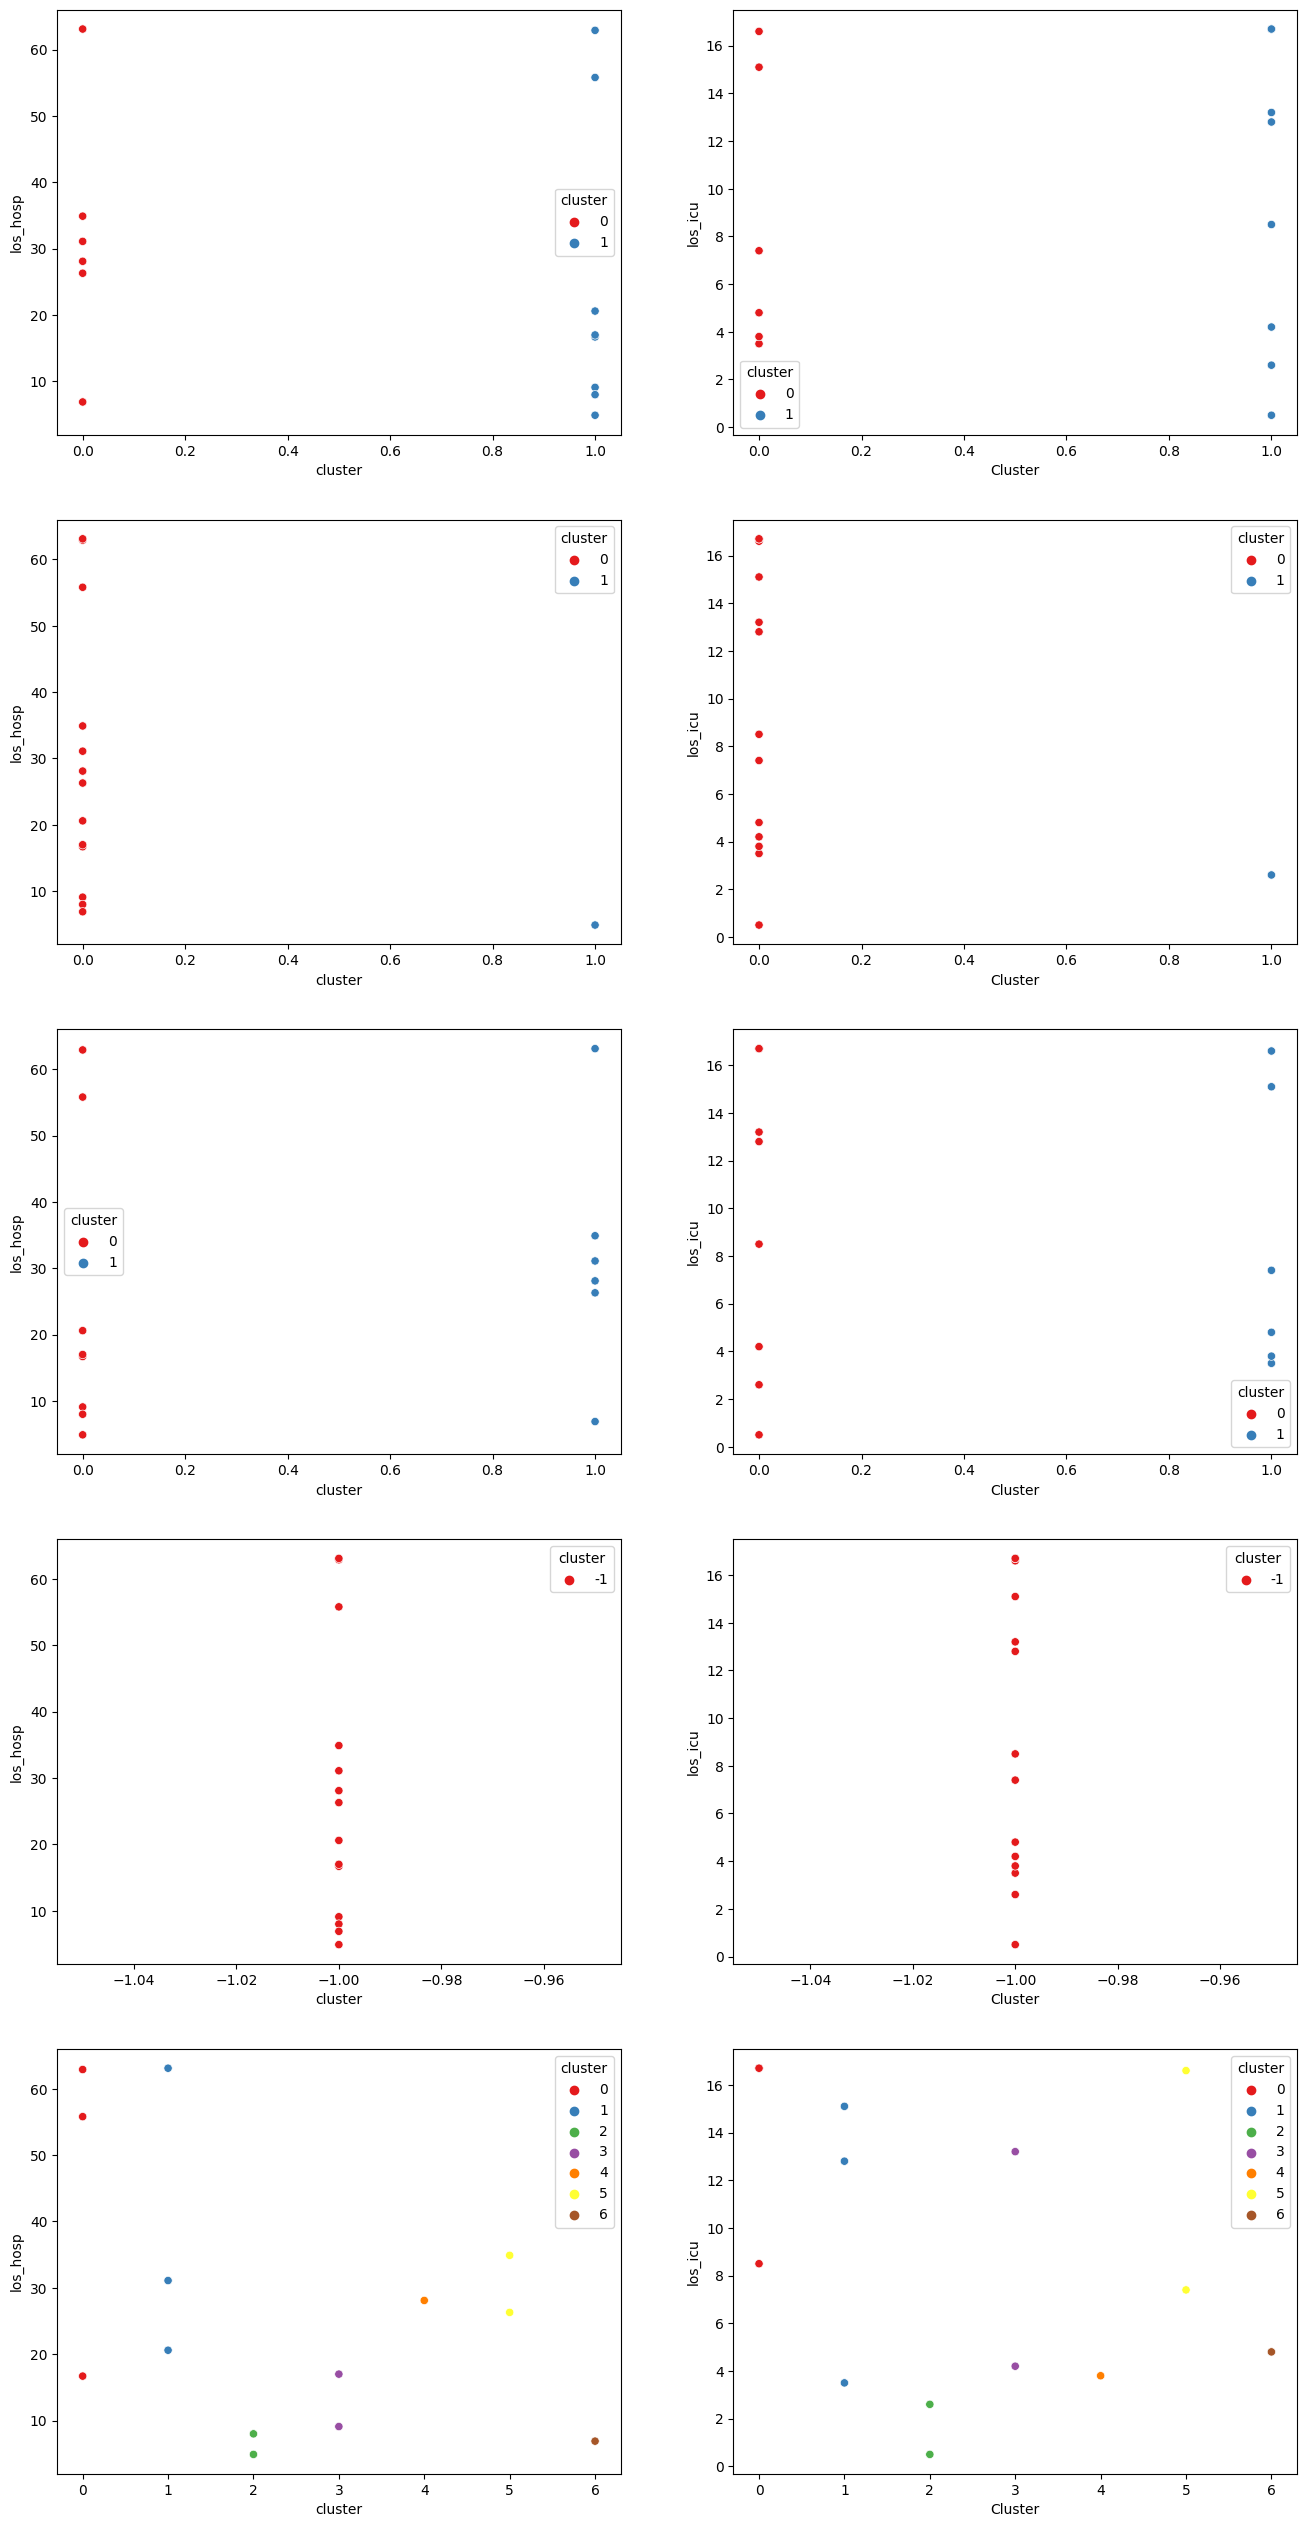

In [103]:
endpoints = ["los_hosp", "los_icu"]

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=len(clusters), ncols=2, figsize=(16, 32))

for col, cluster in enumerate(clusters):
    for row, endpoint in enumerate(endpoints):
        plot_endpoint_for_cluster(
            cohort,
            cluster,
            endpoint,
            x_axis="cluster",
            hue="cluster",
            ax=axes[col][row],
        )
    axes[col].suptitle(cluster.__class__.__name__)
    axes[col][row].set_xlabel("Cluster")
    axes[col][row].set_ylabel(endpoint)
